# Debugging the Data of a Soccer XG model

The task is to predict the probabiliy a shot resulting in a goal given:
 - x-coordinate of shot
 - y-coordinate of shot
 - bodypart=foot
 - bodypart=head
 - bodypart=other
 - prev_action=shot.

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import joblib
import veritas
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xg_penalty_example_util as matplotsoccer
from IPython.core.display import HTML

columns = ["x", "y", "foot", "head", "other", "prev_action"]
icolumns = { k: i for i, k in enumerate(columns) }
field = matplotsoccer.spadl_config

pb_x1 = field["origin_x"] + field["length"] - field["penalty_box_length"]
pb_x2 = field["origin_x"] + field["length"]
pb_y1 = (field["origin_y"] + field["width"]) / 2 - field["penalty_box_width"] / 2
pb_y2 = (field["origin_y"] + field["width"]) / 2 + field["penalty_box_width"] / 2

def minmax_normalize(x):
    m, M = min(x), max(x)
    return (np.array(x)-m) / (M-m)

## Load a pre-trained model

In [3]:
at_orig = veritas.AddTree.read("models/xgb2-xy-basic.json.gz", compressed=True)
splits = {columns[k]: v for k, v in at_orig.get_splits().items()}

## Add two additional trees to the ensemble that penalize the output

... when ...

1. the *bodypart* feature with possible values *foot*, *head*, *other* has no option or multiple options selected (one-hot encoding)
2. the action happens inside of the penalty box

In [4]:
# One-hot constraint penalty tree
at = at_orig.copy()
t = at.add_tree()
t.split(t[""], icolumns["foot"], 1.0)
for p in ["l", "r"]:
    t.split(t[p], icolumns["head"], 1.0)
for p in ["ll", "lr", "rl"]:
    t.split(t[p], icolumns["other"], 1.0)
for p in ["lll", "lrr", "rlr", "rr"]:
    t.set_leaf_value(t[p], 0, -1000.0)

# In penalty box penalty tree
t = at.add_tree()
t.split(t[""], icolumns["y"], pb_y1)
t.split(t["r"], icolumns["y"], pb_y2)
t.split(t["rl"], icolumns["x"], pb_x1)
t.set_leaf_value(t["rlr"], 0, -2000.0)

## Test the one-hot encoding penalty tree

Take a example with no value for *bodypart*.

In [5]:
#                                     v  v  v
test_example = np.array([100.0, 10.2, 0, 0, 0, 0])
print("Invalid one-hot encoding:", at.eval(test_example)[0])

test_example[icolumns["foot"]] = 1.0
print("  Valid one-hot encoding:", at.eval(test_example)[0])

Invalid one-hot encoding: [-1003.37304335]
  Valid one-hot encoding: [-3.36736452]


## Test the penalty box penalty tree

Evaluate the tree for a grid of points covering the full soccer field.

Node(id=0, split=[F1 < 13.85], sz=7, left=1, right=2)
├─ Leaf(id=1, sz=1, value=[0])
├─ Node(id=2, split=[F1 < 54.15], sz=5, left=3, right=4)
│  ├─ Node(id=3, split=[F0 < 88.5], sz=3, left=5, right=6)
│  │  ├─ Leaf(id=5, sz=1, value=[0])
│  │  └─ Leaf(id=6, sz=1, value=[-2000])
│  └─ Leaf(id=4, sz=1, value=[0])



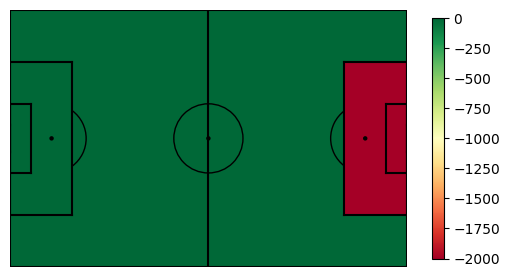

In [6]:
fig, ax = plt.subplots()
ax.axis("off")
matplotsoccer.field(ax)

at_test_pb = veritas.AddTree(1, veritas.AddTreeType.REGR)
at_test_pb.add_tree(at[len(at)-1])

print(at_test_pb[0])

XY = np.array([[x, y] for x in np.linspace(field["origin_x"], field["length"], 200)
                      for y in np.linspace(field["origin_y"], field["width"], 200)])
X = np.hstack((XY, np.ones((XY.shape[0], 1)), np.zeros((XY.shape[0], 3)))) # append foot, head, other, prev_actio
penalties = at_test_pb.eval(X)
#penalties = at.eval(X)

im = ax.imshow(penalties.reshape((200, 200)).T,
          cmap="RdYlGn",
          extent=(field["origin_x"], field["length"],
                  field["origin_y"], field["width"]))
fig.colorbar(im, ax=ax, shrink=0.65)

plt.show()

## Use Veritas to find the most promising positions to shoot from outside of the penalty box

In [7]:
config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
config.stop_when_optimal = False
config.ignore_state_when_worse_than = -2.5

prune_box = {
    icolumns["x"]: veritas.Interval(field["origin_x"], field["length"]),
    icolumns["y"]: veritas.Interval(field["origin_y"], field["width"])
}

search = config.get_search(at, prune_box)

while search.num_solutions() < 1000:
    if search.steps(100) != veritas.StopReason.NONE:
        break

print(f"Solving time: {search.time_since_start():.2f}s")
print("Number of solutions", search.num_solutions())

Solving time: 0.02s
Number of solutions 959


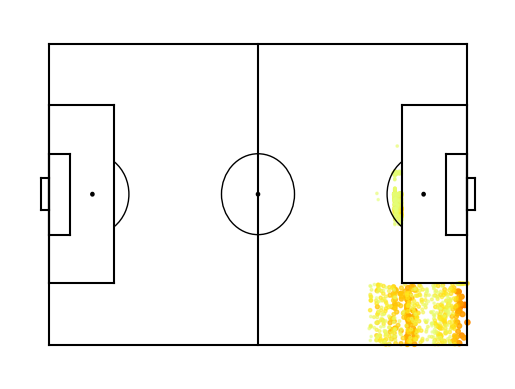

In [8]:
rng = np.random.default_rng(6)

best_positions = []
for i in range(search.num_solutions()):
    sol = search.get_solution(i)
    box = sol.box()

    x = box.get(icolumns["x"], prune_box[icolumns["x"]])
    y = box.get(icolumns["y"], prune_box[icolumns["y"]])

    x = x.lo + rng.random() * (x.hi - x.lo)
    y = y.lo + rng.random() * (y.hi - y.lo)

    #x = x.hi
    #y = y.hi

    best_positions.append((x, y, sol.output))

fig, ax = plt.subplots()
ax.invert_yaxis()
ax.axis("off")
matplotsoccer.field(ax)
ax.scatter([p[0] for p in best_positions],
           [p[1] for p in best_positions],
           s=10 + 50*minmax_normalize([p[2] for p in best_positions]), marker=".",
           c=[p[2] for p in best_positions], cmap="Wistia",
           alpha=0.5 + 0.5*minmax_normalize([p[2] for p in best_positions]))

#fig, ax = plt.subplots()
#ax.hist(1.0 / (1.0 + np.exp([-p[2] for p in best_positions])))

plt.show()

## The most likely states

  x             : Interval(103.469,105)
  y             : Interval(54.3575,68)
  foot          : Interval(>=1)
  head          : Interval(<1)
  other         : Interval(<1)
  prev_action   : Interval(<1)
  output        : -1.3139, -1.3139
  output prob   : 21.2%


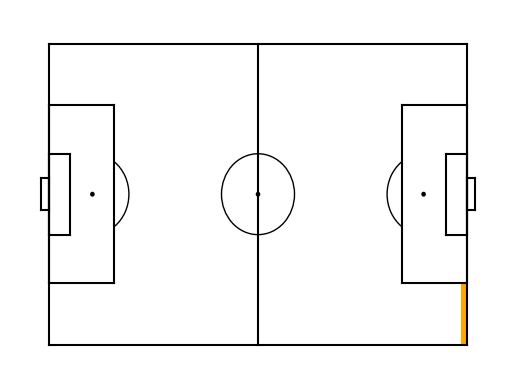

  x             : Interval(102.944,103.469)
  y             : Interval(54.3575,68)
  foot          : Interval(>=1)
  head          : Interval(<1)
  other         : Interval(<1)
  prev_action   : Interval(<1)
  output        : -1.3264, -1.3264
  output prob   : 21.0%


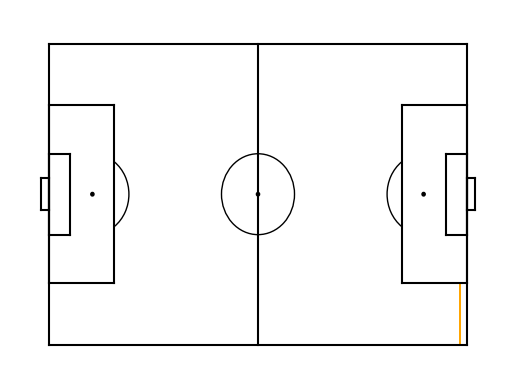

  x             : Interval(103.469,105)
  y             : Interval(54.3575,68)
  foot          : Interval(>=1)
  head          : Interval(<1)
  other         : Interval(<1)
  prev_action   : Interval(>=1)
  output        : -1.4250, -1.4250
  output prob   : 19.4%


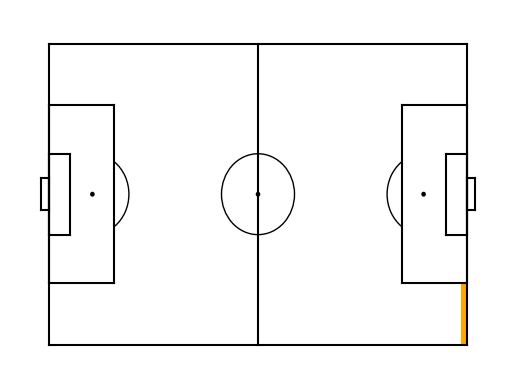

  x             : Interval(102.944,103.469)
  y             : Interval(54.3575,68)
  foot          : Interval(>=1)
  head          : Interval(<1)
  other         : Interval(<1)
  prev_action   : Interval(>=1)
  output        : -1.4376, -1.4376
  output prob   : 19.2%


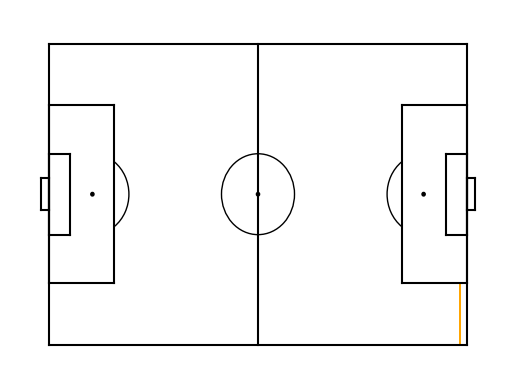

In [9]:
numbers = ["1st", "2nd", "3rd", "4th"]

for i, num in enumerate(numbers):
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.axis("off")
    matplotsoccer.field(ax)

    sol = search.get_solution(i)
    box = sol.box()
    x = box.get(icolumns["x"], prune_box[icolumns["x"]])
    y = box.get(icolumns["y"], prune_box[icolumns["y"]])
    
    ex = veritas.get_closest_example(sol, np.zeros(len(columns)), eps=1e-3)
    
    display(HTML(f"<b>{num} best solution</b>"))
    for k, v in box.items():
        print(f"  {columns[k]:14s}: {v}")
    print(f"  output        : {at.eval(ex)[0,0]:.4f}, {sol.output:.4f}")
    print(f"  output prob   : {100.0 / (1.0 + np.exp(-sol.output)):.1f}%")
    
    r = Rectangle((x.lo, y.lo), x.hi-x.lo, y.hi-y.lo, fc="orange")
    ax.add_patch(r)
    
    plt.show()